# Introduction to Quantum Computing

## Overview 

This notebook provides an introduction to some basic quantum computing concepts and how to program a quantum computer using quantum circuits.

We recommend you have some knowledge of:
* Python programming: language, importing libraries, using functions.
* basic quantum computing concepts: qubits, quantum processes like superposition, interference and entanglement.

### Learning Objects 

After using this notebook you should have an understanding of 

* What are *qubits* and why they are different from classical binary bits.
* What is *superposition* and how it could be used to solve a problem.
* What is *interference & entanglement* and how it could be used to solve a problem.
* What are *quantum circuits* and how they relate to solving a problem. 


## Python Refresher 

Python is an interpreted, high-level, and general-purpose programming language created by Guido van Rossum and first released in 1991. It emphasizes readability and simplicity, making it ideal for both beginners and experienced developers. Python supports multiple programming paradigms, including procedural, object-oriented, and functional programming. It's widely used for web development, data analysis, artificial intelligence, scientific computing, and more due to its extensive standard library and community support. 


### Examples

We do not provide an introduction to the Python programming lanuage but quickly refresh some relevant examples below.

1. Print Hello
   ```python
   print("Hello, World!")
   ```
3. Declaring some variables and doing some mathematical operations
   ```python
   a = 5
   b = 3
   sum = a + b
   print("Sum:", sum)
   ```
4. Define a function
   ```python
   def greet(name):
     return f"Hello, {name}!"
   print(greet("Alice"))
   ```
5. Import a library
   ```python
   # import the numerical library of python
   import numpy as np 
   # create an array of ones of size 5, ie: [1,1,1,1,1]
   x = np.ones(5)
   print(x)
   ```


In [3]:
# here lets import and set some python/jupyter preliminaries
%matplotlib inline

# generic plotting library 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.logging.getLogger('matplotlib.font_manager').disabled = True

# penny lane quantum computing library
import pennylane as qml
from pennylane import numpy as np
qml.drawer.use_style('sketch')

# quatnum music visualisation 
import qmuvi
from qiskit import QuantumCircuit

In [4]:
# some helper function definitions

def PlotPennyLaneHisto(results, plottitle : str = ''):
    with plt.xkcd():
    # Based on "Stove Ownership" from XKCD by Randall Munroe
    # https://xkcd.com/418/

        fig = plt.figure()
        ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
        ax.spines[['top', 'right']].set_visible(False)
        labels = [rf'$|{k}>$' for k in results.keys()]
        xvals = np.arange(len(results.keys()))
        yvals = [results[k] for k in results.keys()]
        ax.bar(labels, yvals, facecolor='DarkOrange', edgecolor='Gold', linewidth=4)
        ax.set_xlabel('Qubit States')
        ax.set_ylabel('Count')
        ax.set_title(plottitle)
        fig.show()


## Qubits

#### PJE add figure of bit vs qubit

Before discussing a quantum bit, so-called *qubit*, it is important to understand how *classical* computers like the one running this notebook operate and what a classical binary bit is. 

### Classical Bit 
A bit is a digital representation of either 0 *or* 1. This simple bit can be used to represent a number of numbers (see [https://en.wikipedia.org/wiki/Binary_number]). The binary representation of numbers such as 12 can be done by combining several bits together. In the case of 4 bits, you can view the combination as a sum where each bit represents a power of 2: the first bit being indicating an on/off of $2^0=1$; second bit $2^1=2$; third $2^2=4$; fourth $2^3=8$. 

#### Examples 
* 0000: This represents the decimal number 0 as you have $0\times2^{0}+0\times2^{1}+0\times2^{2}+0\times2^{3}$.
* 0001: This represents the decimal number 1.
* 0010: This represents the decimal number 2.
* 0100: This represents the decimal number 4.
* 1010: This represents the decimal number 10 as you have $0\times2^{0}+1\times2^{1}+0\times2^{2}+1\times2^{3} = 2+8 = 10$.

*What is 12?*

### Quantum Bit
A qubit is a fundamental unit of quantum information, analogous to the classical bit. However, here the quantum state holding the information can exist in a *superposition* of states, meaning they can be 0, 1, or ***both 0 and 1 simultaneously***! 


This means that a qubit can store more information than a classical bit, exponentially more information. For instance to store the information in 4-qubit structure, storing all the various possible values, you need $2^{4}=32$ bits. That may not seem like much but when you get large number of qubits, say 100 qubits, you would need $2^100=1,267,650,600,228,229,401,496,703,205,376$ bits, which is roughly a thousand, billion, billon Gigabytes of memory!

Often you'll see that qubits are written a little differently (using the so-called *braket* or *Dirac* notation). The 0-state is often written as $\ket{0}$ and 1 as $\ket{1}$. A 4-bit qubit, with qubits $q_0, q_1, q_2, q_3$ is $\ket{q_1q_2q_3q_4}$. 


*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Qubit).*

## Quantum Superposition & Measurement

#### PJE add figure of superposition

Superposition is one of the core principles of quantum mechanics and, by extension, quantum computing, which states that a qubit can be in both 0 and 1 states at the same time$^\dagger$. For a *qubit* $\ket{\Psi}$ in general superposition, one can think of it as 
$$
\ket{\Psi} = c_0\ket{0}+c_1\ket{1}
$$

This mixed state is **NOT** directly measured. Instead measurement of a qubit will return a $\ket{0}$ **or** $\ket{1}$, *not both*. 

*How do you know the qubit was in a mixed state before the measurement occurs?* **By repeating the experiment and measurment.** You will see that the qubit will be 0 or 1 with the probability being $c_0\times c_0$ or $c_1\times c_1$ respectively.

> $\dagger$ Specifically linear combinations of solutions to the *Schrödinger equation* governing the evolution of quantum systems are also solutions of the Schrödinger equation. The state of a system is given by a linear combination of all the eigenfunctions of the Schrödinger equation governing that system.

A commonly used superposition state is one of *equal* superposition where $c_0 = c_1 = c = \tfrac{1}{\sqrt{2}}$. That is the probabilty of getting a 0 is the same as 1 and you can get either 0 and 1 $50\%$ of the time (like a coin flip). 
$$
\ket{\Psi} = c\bigl(\ket{0} + \ket{1}\bigr)
$$

Now it is important to realise that this mixed state is NOT directly measured (that is you don't see the coin land on its edge). Instead, if you didn't know the state of the system, you would have to *measure* or observe it over and over again and see that you would get $\ket{0}$ sometimes and $\ket{1}$ other times. Think of a spinning coin that when you catch it, it has a specific state. 

*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Quantum_superposition).*

## Quantum Interference & Entanglement 

#### PJE add figure of entanglement

Quantum entanglement is the a unique feature of quantum mechanics (the physics that governs the small-scale universe) that not present in classical mechanics that well describes our day-to-day world (cars, planes, footballs). The phenomenon is when quantum states are interacting in such a way that the quantum state of each particle of the group cannot be described independently of the state of the others, even when particles are separated by a large distance. It is often referred to as a "spooky-action-at-a-distance" but there is nothing ghostly about it. 

### The Qubit perspective 

Let's think about *qubits*. Let's say we have two qubits $\ket{\Psi_1}$ \& $\ket{\Psi_2}$ and a total system state of $\ket{\Psi} = \ket{\Psi_1\Psi_2}$. Now if qubit 1 was in the $\ket{0}$ state and qubit 2 was in $\ket{1}$, then the total system state is written as 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = \ket{01}
$$
Similar if we had instead both in the $\ket{0}$ state we often write this as $\ket{00}$ or if we had both in the $\ket{1}$ state, then we write the state as $\ket{11}$. 

Now consider these qubits if they are both in *equal* superposition. The total state of the system, $\ket{\Psi}$ is 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = c\times c \bigl(\ket{00}+ \ket{01}+\ket{10}+\ket{11}\bigr)
$$

Here we would measure each of the total possible set of states equally. Consider this as if you were flipping two independent coins. But what happens if we ***entangle*** these states such that if qubit 2 is linked to the state of qubit 1. You get a $\ket{0}$ for qubit 1, you get a $\ket{0}$ for qubit 2 (that is the coins are linked). In this case we cannot get the states $\ket{01}$ and $\ket{10}$ because the states are entangled. 

Now consider these qubits if they are both in *equal* superposition. The total state of the system, $\ket{\Psi}$ is 
$$
\ket{\Psi} = \ket{\Psi_1\Psi_2} = c\bigl(\ket{00}+\ket{11}\bigr)
$$


*For more information, see [wikipedia](https://en.wikipedia.org/wiki/Quantum_entanglement).*

## Quantum Circuits

In standard computing you write a computer program that can executed by a classical computer. These programs can consist of many different steps and you can often jump around in the steps (for instance do and undo) and these can be done interactively.

Quantum programs (or algorithms) are a bit different as it can be tricky to dynamically interact with the quantum system without ruining the qubits. It is also challenging to visualise what is happening in a quantum program and we often visualise what is happening using a  *quantum circuit*. An example of a quantum circuit is shown below. 

![3 Qubit Circuit](simple_circuit_annotated_small.png "3 Qubit circuit")

This shows the evolution of qubits as a single line going from left to right. If you ever see a doubled lines that represent a classical bit. Quantum gates are shows as symbols on the line and the entire program is this sequence of operations on qubits.  These lines define the sequence of events, and are usually not physical cables. 

This is a nice way fo visualising a quantum program as it can show what happens to a given qubit and also which qubits are interacting (as shown by vertical lines with symbols ending on the qubit lines). 

Below is a way of making a nice visualisation of a quantum circuit where the point at which you are on the circuit is highlighted. 

*Don't worry about the details yet, let's just enjoy*

In [11]:
import qmuvi
from qiskit import QuantumCircuit

circ = QuantumCircuit(2)
circ.barrier()
circ.h(0)
circ.barrier()
circ.cx(0, 1)
circ.barrier()

qmuvi.generate_qmuvi(circ, "bell_state")

Generating qMuVi data...
Generating MIDI track files...
Converting to .wav files using TiMidity++
Errors in thread 0:


CalledProcessError: Command '['/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/binaries/TiMidity-2.15.0/macos/timidity', '-Ow', '--preserve-silence', '-A,120', '--no-anti-alias', '--mod-wheel', '--portamento', '--vibrato', '--no-ch-pressure', '--mod-envelope', '--trace-text-meta', '--overlap-voice', '--default-bank=0', '--default-program=0', '--delay=d,0', '--chorus=n,64', '--reverb=f,40,0.28,0.7,100', '--voice-lpf=c', '--noise-shaping=4', '--resample=5', '--voice-queue=0', '--decay-time=0', '--interpolation=gauss', '-EFresamp=34', '--output-stereo', '--output-24bit', '--polyphony=15887', '--sampling-freq=44100', '--volume-curve=1.661', '--config-file="/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/resources/timidity/timidity.cfg"', '-o', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/bell_state-output/bell_state-4.wav"', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/bell_state-output/bell_state-4.mid"']' died with <Signals.SIGABRT: 6>.

## Simulating Quantum Computers and running Quantum Circuits

There are a variety of tools out there which can simulate a quantum computer (albeit slowly and only for small qubit counts). In this notebook, we'll make use of a few of them, namely [**PennyLane**](https://pennylane.ai/) and [**Qiskit**](https://www.ibm.com/quantum/qiskit). We'll also use some nice tools like [**qmuvi**](https://github.com/garymooney/qmuvi) a visualisation tool and [**matplotlib**](https://matplotlib.org/)

### PennyLane
PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. We won't make use of all the functionality but the basics is that you can make use of a quantum computer simulator by invoking a device. 

```python
import pennylane as qml
# here `wires
qml.device('default.qubit', wires=number_of_qubits)
```

You'll note some funny terminology such as `pennylane` often invoked as `qml` and `wires` being the number of qubits. Then to construct a circuit you need to define a function that places gates (operations) on the qubits in the circuit.

```python
# let's define a 2-qubit circuit that has some gates (to be discussed later)
def circuit():
    qml.NOT(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT([1,0])
    return qml.counts(all_outcomes=True)

```

We'll make use of these basic idea's later. 

### Qiskit
Qiskit is another library for quantum computing. Like PennyLane it has lots of nice functionality for simulating and working with quantum circuits.

```python
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
# Add a NOT gate on qubit 1
qc.x(0)
# Add a Hadamard gate to qubit 1
qc.h(1)
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
```

## Superposition or Hadamard Gate

One of the simplest instructions or operations you can apply to a qubit is the *Hadamard* gate, $H$, which essentially implements superposition, turning a state of $\ket{0}$ or $\ket{1}$ into an equal superposition of $\ket{0}$ and $\ket{1}$. More precisely 
$$H\ket{0} = \frac{\ket{0}+\ket{1}}{\sqrt{2}}, \quad H\ket{1} = \frac{\ket{0}-\ket{1}}{\sqrt{2}}$$

In both cases, one changes the qubit from just return it's initial state when being measured to giving either 0 or 1 with $50\%$ probability. 

Let's consider a quantum circuit consisting of a single qubit starting in $\ket{0}$ and applying a Hadarmard gate. 

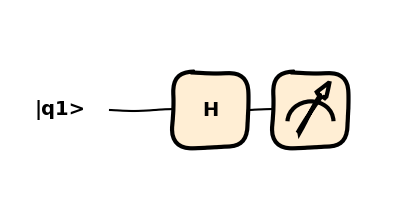

In [8]:
# sample code to draw a hadarmad gate using PennyLane
# here 
dev = qml.device("default.qubit", wires=["|q1>"])

# now simple circiut where we return the state of the qubits
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires="|q1>")
    return qml.counts(all_outcomes=True)

# plot the circuit
fig, ax = qml.draw_mpl(circuit)()

What could we expect if we measured the output of this circuit 10 times? 100 times? What happens if you do 1000 times?

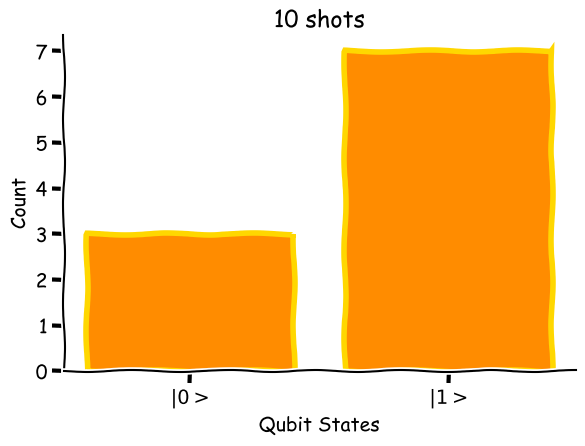

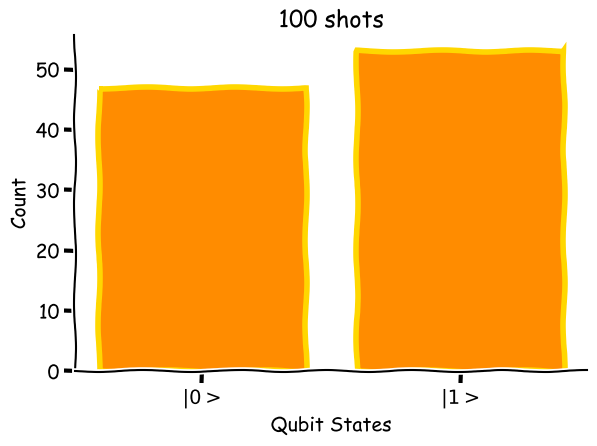

In [9]:
# lets create a quantum device that will take 10 shots
results = circuit(shots=10)
# here plot the results
PlotPennyLaneHisto(results, '10 shots')

# now you try running more shots by running the circuit again. 
results = circuit(shots=100)
# here plot the results
PlotPennyLaneHisto(results, '100 shots')

# what would you expect if you could infinitly sample the simple circuit?


To gain more understainding, let's look at using the **qmuvi** visualisation tool to see what is happening with the Hadamard gate. In a classical system, you can only have 0 or 1 but in the quantum system, while the state is not measured, it is a real mixture of 0 and 1. Let's consider a musical analogue. If we considered 0 to be a note and 1 being another then we should expect the music to start with a single note before the Hadamard gate is placed, then it should become two notes and when measured go back to one of the notes. 

Here we'll have to use Qiskit to create the circuit 

In [10]:
# c
circuit = QuantumCircuit(1)
# Barrier gates tell qMuVi where to sample the state in the circuit. It's like you are measuring the system with out truly collapsing the state
circuit.barrier()
circuit.h(0)
circuit.barrier()
# how to measure with qiskit that works with qmuvi?
#circuit.

qmuvi.generate_qmuvi(circuit, "hadamard")

Generating qMuVi data...
Generating MIDI track files...
Converting to .wav files using TiMidity++
Errors in thread 0:


CalledProcessError: Command '['/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/binaries/TiMidity-2.15.0/macos/timidity', '-Ow', '--preserve-silence', '-A,120', '--no-anti-alias', '--mod-wheel', '--portamento', '--vibrato', '--no-ch-pressure', '--mod-envelope', '--trace-text-meta', '--overlap-voice', '--default-bank=0', '--default-program=0', '--delay=d,0', '--chorus=n,64', '--reverb=f,40,0.28,0.7,100', '--voice-lpf=c', '--noise-shaping=4', '--resample=5', '--voice-queue=0', '--decay-time=0', '--interpolation=gauss', '-EFresamp=34', '--output-stereo', '--output-24bit', '--polyphony=15887', '--sampling-freq=44100', '--volume-curve=1.661', '--config-file="/Users/ela017/software/pyvenv/lib/python3.9/site-packages/qmuvi/package_data/resources/timidity/timidity.cfg"', '-o', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/hadamard-output/hadamard-4.wav"', '"/Users/ela017/myresearch/quantumcomputing/quantum-computing-hackathon/lessons/hadamard-output/hadamard-4.mid"']' died with <Signals.SIGABRT: 6>.

## Entanglement or "CNOT" Gate


In [ ]:
# Here is the boiler plate
dev = qml.device("default.qubit", wires=)
@qml.qnode(dev)
def circuit():
    # add your circuits here
    return qml.counts(all_outcomes=True)
# then run the circuit and plot the result. How many shots do you think you need to take to really get the ideal (true) result?
results = 
PlotPennyLaneHisto(results, '100 shots')


# BELOW MUST REMOVE

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded = files.upload()

In [ ]:
Image('Screenshot_2024-01-29_213651.png', width = 525)

The circuit can be used as a guide towards writing the program. We will first code the Deutsch-Jozsa algorithm using qubits before generalizing it to qutrits to get a basic understanding of how the algorithm works.

In [ ]:

# Downloading and importing all necessary libraries
!pip install pennylane pennylane-qiskit
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt


In [ ]:

# Defining the quantum device with n+1 qubits
n = 3
dev = qml.device("default.qubit", wires = n+1)

# Defining the Deutsch-Jozsa algorithm
@qml.qnode(dev)

def dj_algorithm(case, n):
    # Setting up the output qubit
    qml.PauliX(wires=n)
    qml.Hadamard(wires=n)

    # Setting up the input register
    for qubit in range(n):
        qml.Hadamard(wires=qubit)

    # Appending the oracle Uf
    if case == "balanced":
        b = np.random.randint(1, 2**n)
        b_str = format(b, '0'+str(n)+'b')

        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                qml.PauliX(wires=qubit)

        for qubit in range(n):
            qml.CNOT(wires=[qubit, n])

        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                qml.PauliX(wires=qubit)

    elif case == "constant":
        output = np.random.randint(2)
        if output == 1:
            qml.PauliX(wires=n)

    # Performing H-gates again and measuring
    for qubit in range(n):
        qml.Hadamard(wires=qubit)

    return qml.probs(wires=range(n))

# Runing the circuit
result = dj_algorithm('constant', n)

# Obtaining each input state
x_values = range(2**n)
input_states = [format(i, '0'+str(n)+'b') for i in x_values]

# Converting probabilities to a NumPy array for plotting
probabilities = np.array(result)

# Ploting the bar chart using numpy and matplotlib
plt.bar(input_states, probabilities, color='blue', alpha=0.7)
plt.ylabel('Probability')
plt.title('Probability Distribution')
plt.show()


With 3 qubits and a constant oracle, we are expected to get a probability of 1 at '000', indicating that there is a 0% chance of measuring '111'. The output above verifies our assumption; hence, verifying the constant function.

Now, let us rerun the program with a balanced oracle:

In [ ]:

# Defining the quantum device with n+1 qubits
n = 3
dev = qml.device("default.qubit", wires = n+1)

# Defining the Deutsch-Jozsa algorithm
@qml.qnode(dev)

def dj_algorithm(case, n):
    # Setting up the output qubit
    qml.PauliX(wires=n)
    qml.Hadamard(wires=n)

    # Setting up the input register
    for qubit in range(n):
        qml.Hadamard(wires=qubit)

    # Appending the oracle Uf
    if case == "balanced":
        b = np.random.randint(1, 2**n)
        b_str = format(b, '0'+str(n)+'b')

        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                qml.PauliX(wires=qubit)

        for qubit in range(n):
            qml.CNOT(wires=[qubit, n])

        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                qml.PauliX(wires=qubit)

    elif case == "constant":
        output = np.random.randint(2)
        if output == 1:
            qml.PauliX(wires=n)

    # Performing H-gates again and measuring
    for qubit in range(n):
        qml.Hadamard(wires=qubit)

    return qml.probs(wires=range(n))

# Runing the circuit
result = dj_algorithm('balanced', n)

# Obtaining each input state
x_values = range(2**n)
input_states = [format(i, '0'+str(n)+'b') for i in x_values]

# Converting probabilities to a NumPy array for plotting
probabilities = np.array(result)

# Ploting the bar chart using numpy and matplotlib
plt.bar(input_states, probabilities, color='blue', alpha=0.7)
plt.ylabel('Probability')
plt.title('Probability Distribution')
plt.show()


The program again correctly outputs the expected probability of 1 at '111' indicating that there is a 0% chance of obtaining a '000' when the function is balanced.

The algorithm can be run using any arbitrary number of qubits, and the resulting probabilites would always be same, with the only difference being the number of zeroes and ones in the input state.

## **Extending to Qutrits**

Now let us look at the Deutsch-Jozsa algorithm but for Qutrits:

Initially, the algorithm prepares the quantum system in a superposition of all possible inputs. When working with qubits, the function takes $n$  bits as input and the quantum system is prepared in a superposition of $2^n$  states. When working with qutrits,the function takes $n$ qutrits as an input and the quantum system is prepared in a superposition of $3^n$ states. The first  $n−1$  qubits are set to  $|0⟩$ , while the final qubit is set to $|2⟩$ . The superposition is then achieved by applying a Hadamard gate on all the qutrits.

Before we can understand the superposition, we must first understand how Hadamard gates extend to qutrits. The following equation represents a Hadamard gate for a qutrit:

$$H|\vec{x}⟩ = \frac{1}{\sqrt{3}} \sum_{\vec{z}=0}^{2}\limits e^{\frac{-i2\pi}{3}(\vec{x}\cdot\vec{z})}|\vec{z}⟩$$



The negative factor in the exponent is a phase shift, and since we are only concerned with the superposition of the quantum system, it can be ignored:

$$H|\vec{x}⟩ = \frac{1}{\sqrt{3}} \sum_{\vec{z}=0}^{2}\limits e^{\frac{i2\pi}{3}(\vec{x}\cdot \vec{z})}|\vec{z}⟩$$



The multiplication of two Hadamard Gates for qutrits can be expressed via the following equation:


$$H \otimes H|\vec{x}⟩ = \frac{1}{\sqrt{3^2}} \sum_{\vec{z_1},\vec{z_2} = 0}^{3^2 - 1}\limits e^{\frac{i2\pi}{3}(\vec{x_1}\cdot \vec{z_1} + \vec{x_2}\cdot \vec{z_2})}|\vec{z_1}\vec{z_2}⟩$$



Going forward we will write

$\vec{x_1}\cdot \vec{z_1} + \vec{x_2}\cdot \vec{z_2} + \dotsb + \vec{x_n}\cdot\vec{z_n}$ as $\bar{x}\cdot\bar{z}$.

$|\vec{z_1}\vec{z_1}\dotsm\vec{z_n}⟩$ as $|\bar{z}⟩$

and $\vec{z_1},\vec{z_1},\dotsc,\vec{z_n}$ as $\bar{z}$.

Thus with our new notation, the multipication of $n$ Hadamard Gates of qutrits can be represented as follows:

$$H^{\otimes n}|\vec{x}⟩ = \frac{1}{\sqrt{3^n}} \sum_{\bar{z} = 0}^{3^n - 1}\limits e^{\frac{i2\pi}{3}(\bar{x}\cdot \bar{z})}|\bar{z}⟩$$



We are now ready to see what the superposition of $n$ qutrits looks like, with $w = e^{\frac{i2\pi}{3}}$:

$$\frac{1}{\sqrt{3^n}} \sum_{\bar{z} = 0}^{3^n - 1}\limits w^{(\bar{x} \cdot \bar{z})}|\bar{z}⟩$$


Just like with qubits, we now apply the oracle and reach the following measurement state:

$$|\psi⟩ =  \frac{1}{3^n} \sum_{\bar{z} = 0}^{3^n-1} \sum_{\bar{x} = 0}^{3^n-1}w^{(\bar{x}\cdot\bar{z}) + f(\bar{x})}|\bar{z}⟩$$

With $f(x)$ representing the mapping that is either balanced or constant.

The above measurement state yields the following representation when $f(x)$ is constant:

$$|\psi⟩ = w^{f(0)}|0⟩$$

## **Coding the qutrit implementation of Deutsch-Jozsa**

Our primary goal is to extend the Deutsch-Jozsa algorithm to qutrits and analyze if it generalizes easily or not. A few key things to keep into consideration would be transitioning from base-2 to base-3 and a change in the number of possible states from $2^n$ to $3^n$.

Let's use the following circuit as a guide towards writing the code for our Deutsch-Jozsa implementation using qutrits:

In [ ]:
uploaded2 = uploaded = files.upload()

In [ ]:
Image('Screenshot 2024-01-30 063702 (1).png', width = 525)

The quantum gates also change when we are dealing with third dimensional systems. Fortunately, PennyLane provides us with most of the gates that we will be needing for implementing this algorithm using qutrits. The 'Hadamard' function changes to 'THadamard' and the 'PauliX' function changes to 'TShift'. For the qutrit CNOT gate, we define a custom unitary matrix, and this gives us everything we need to write the code.

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

n = 2

# Define the quantum device with n+1 qutrits
dev = qml.device("default.qutrit", wires=n+1)

# CNOT gate for qutrits
cnot_qutrit = np.array     ([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 1, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 1],
                             [0, 0, 0, 0, 0, 0, 1, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 1, 0],
                             [0, 0, 0, 0, 0, 1, 0, 0, 0],
                             [0, 0, 0, 1, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0, 0, 0, 0]])

# Define the Deutsch-Jozsa algorithm in PennyLane
@qml.qnode(dev)
def dj_algorithm(case, n):
    # Set up the output qutrit
    qml.TShift(wires=n)
    qml.THadamard(wires=n)

    # Set up the input register
    for qutrit in range(n):
        qml.THadamard(wires=qutrit)

    # Append the oracle gate
    if case == "balanced":
        b = np.random.randint(1, 3**n)
        b_str = np.base_repr(b, base=3)

        for qutrit in range(len(b_str)):
            if (b_str[qutrit] == ('1')) or (b_str[qutrit] == ('2')):
                qml.TShift(wires=qutrit)

        for qutrit in range(n):
            qml.QutritUnitary(cnot_qutrit, wires = [qutrit, n])

        for qutrit in range(len(b_str)):
            if (b_str[qutrit] == ('1')) or (b_str[qutrit] == ('2')):
                qml.TShift(wires=qutrit)

    elif case == "constant":
        output = np.random.randint(2)
        if (output == 1) or (output == 2):
            qml.TShift(wires=n)

    # Perform H-gates again and measure
    for qutrit in range(n):
        qml.THadamard(wires=qutrit)

    return qml.probs(wires=range(n))

# Run the circuits
result = dj_algorithm('constant', n)

# Displaying the probabilities
states = [''.join(str((i // (3 ** j)) % 3) for j in range(n - 1, -1, -1)) for i in range(3 ** n)]
plt.bar(states, result, color='blue', alpha=0.7)
plt.ylabel('Probability')
plt.title('Probability Distribution')
plt.show()

With 2 qutrits and a constant oracle, our expected output of obtaining a probability of 1 at |00> is verified. Using this result, we can certainly infer that the Deutsch-jozsa algorithm adapts well when the oracle is constant.

Considering the case of a balanced oracle now:

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

n = 2

# Define the quantum device with n+1 qutrits
dev = qml.device("default.qutrit", wires=n+1)

# CNOT gate for qutrits
cnot_qutrit = np.array     ([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                             [0, 1, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 0, 1],
                             [0, 0, 0, 0, 0, 0, 1, 0, 0],
                             [0, 0, 0, 0, 0, 0, 0, 1, 0],
                             [0, 0, 0, 0, 0, 1, 0, 0, 0],
                             [0, 0, 0, 1, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0, 0, 0, 0]])

# Define the Deutsch-Jozsa algorithm in PennyLane
@qml.qnode(dev)
def dj_algorithm(case, n):
    # Set up the output qutrit
    qml.TShift(wires=n)
    qml.THadamard(wires=n)

    # Set up the input register
    for qutrit in range(n):
        qml.THadamard(wires=qutrit)

    # Append the oracle gate
    if case == "balanced":
        b = np.random.randint(1, 3**n)
        b_str = np.base_repr(b, base=3)

        for qutrit in range(len(b_str)):
            if (b_str[qutrit] == ('1')) or (b_str[qutrit] == ('2')):
                qml.TShift(wires=qutrit)

        for qutrit in range(n):
            qml.QutritUnitary(cnot_qutrit, wires = [qutrit, n])

        for qutrit in range(len(b_str)):
            if (b_str[qutrit] == ('1')) or (b_str[qutrit] == ('2')):
                qml.TShift(wires=qutrit)

    elif case == "constant":
        output = np.random.randint(2)
        if (output == 1) or (output == 2):
            qml.TShift(wires=n)

    # Perform H-gates again and measure
    for qutrit in range(n):
        qml.THadamard(wires=qutrit)

    return qml.probs(wires=range(n))

# Run the circuits
result = dj_algorithm('balanced', n)

# Displaying the probabilities
states = [''.join(str((i // (3 ** j)) % 3) for j in range(n - 1, -1, -1)) for i in range(3 ** n)]
plt.bar(states, result, color='blue', alpha=0.7)
plt.ylabel('Probability')
plt.title('Probability Distribution')
plt.show()

The output obtained is rather interesting, but even more abstract in the sense that it does not particularly reveal the nature of the oracle. Obtaining a superposition between states means that we cannot say with certainty if the function is constant or balanced.

## **Conclusion**

We were able to simulate the expected outcome when working with constant oracles. However, it turns out that Deutsch-Jozsa for qubits does not generalize as easily for qutrits when it comes to balanced functions. Running the simulation multiple times leads us to the same result repetitively implying that either it is impossible to identify a balanced function using the standard Deutsch-Jozsa algorithm for qubits that has been extended to qutrits, or a balanced case simply does not exist for qutrits and the function is neither constant nor balanced.

## **References**

https://github.com/filipecorrea/deutsch-jozsa/blob/master/deutsch-jozsa.ipynb

https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=2b8bbd69f4e682f6ce6ea7597961d26c5441f287

https://pennylane.ai/qml/demos/tutorial_qutrits_bernstein_vazirani/

https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm

https://www.iosrjournals.org/iosr-jap/papers/Vol10-issue6/Version-2/D1006021619.pdf